## Basic Neural ODE and Augmented Neural ODE

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchdiffeq import odeint

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset Preparation

In [3]:
class SeismicDataset(Dataset):
    def __init__(self, data_pairs):
        self.data = []
        self.targets = []
        for seismic_path, velocity_path in data_pairs:
            seismic = np.load(seismic_path)
            velocity = np.load(velocity_path)
            self.data.append(torch.from_numpy(seismic).float())
            self.targets.append(torch.from_numpy(velocity).float())

        self.data = torch.cat(self.data, dim=0)
        self.targets = torch.cat(self.targets, dim=0)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

# Collect data file pairs
data_pairs = [
    ('FlatVel_A/data/data1.npy', 'FlatVel_A/model/model1.npy'),
    ('CurveFault_A/seis2_1_0.npy', 'CurveFault_A/vel2_1_0.npy'),
    ('FlatFault_A/seis2_1_0.npy', 'FlatFault_A/vel2_1_0.npy'),
    ('Style_A/data/data1.npy', 'Style_A/model/model1.npy')
]

dataset = SeismicDataset(data_pairs)

In [4]:
# Split into train and validation
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Encoder

In [5]:
class SeismicEncoder(nn.Module):
    def __init__(self, latent_state=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),                          
            nn.Flatten(),                                          
            nn.Linear(64, latent_state)
        )

    def forward(self, x):  # x: (batch_size, num_sources, timesteps, num_receivers)
        B, C, T, S = x.shape
        x = x.to(device)
        x = x.permute(0, 2, 1, 3)     
        x = x.reshape(B * T, C, 1, S) 
        output = self.encoder(x).to(device)     
        return output.view(B, T, -1)

### Base Function

In [6]:
class ODEFunc(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.func = nn.Sequential(
            nn.Linear(out_size+1, 128),
            nn.Softplus(),
            nn.Linear(128, 256),
            nn.Softplus(),
            nn.Linear(256, out_size)
        )
    def forward(self, t, x):
        if t is None:
            t =  torch.ones(x.shape[0], x.shape[1], 1, device = x.device)
        elif isinstance(t, float) or t.ndim == 0:
            t = torch.ones(x.shape[0], x.shape[1], 1, device = x.device)*t
        else: 
            t = t
        # print(x.shape)
        # print(t.shape)
        x = x.to(device)
        t = t.to(device)
        x = torch.cat((x, t), dim=-1)
        x = self.func(x)
        return x

### Decoder

In [7]:
class VelocityDecoder(nn.Module):
    def __init__(self, latent_state=64):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_state, 32 * 9 * 9),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1),
            nn.AdaptiveAvgPool2d((70,70))
        )
    def forward(self, x):
        x = x.to(device)
        x = self.decoder(x)        
        x = x.view(-1, 32, 9, 9)
        x = self.deconv(x)
        return x

### Full Basic Neural ODE Model

In [8]:
class NeuralODE(nn.Module):
    def __init__(self, latent_state, tolerance, max_steps):
        super().__init__()
        self.encoder = SeismicEncoder(latent_state)
        self.decoder = VelocityDecoder(latent_state) 
        self.neural_ode_model = ODEFunc(latent_state)
        self.tolerance = tolerance
        self.max_steps = max_steps
    
    def forward(self, x, times=None):
        x = x.to(device)
        x = self.encoder(x)
        if times is None:
            times = torch.tensor([0, 1]).float().type_as(x)
            times = times.to(device)
        y = odeint(func=self.neural_ode_model, 
                   y0=x, 
                   t=times, 
                   atol=self.tolerance, 
                   rtol=self.tolerance, 
                   method='dopri5', 
                   options={'max_num_steps':self.max_steps})
        # print(y.shape)
        _, batch_size, timestep, latent = y.shape
        pred = self.decoder(y)
        pred = pred.to(device)
        pred = pred.view(timestep, batch_size, 1, 70, 70)
        return pred

### Training

In [9]:
model = NeuralODE(64, 1e-3, 100)
step_size = 10
# model = model.to(device)
# Define loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

# Training loop
num_epochs = 50

model = model.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        B, __, T, C = inputs.shape
        times = torch.linspace(0, 1, steps=5, device=device)
        # times = torch.Tensor([1.0]).to(device)
        outputs = model(times=times,x=inputs)
        outputs = outputs.squeeze(0)
        outputs = outputs[-1,:]
        # aug = torch.zeros(targets.shape[0], targets.shape[1], targets.shape[2], targets.shape[3])
        # aug = aug.to(device)
        # targets = torch.cat([targets, aug], -1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    scheduler.step()
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            times = torch.linspace(0, 1, steps=5, device=device)
            # times = torch.tensor([1.0]).to(device)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(times=times, x=inputs)
            outputs = outputs.squeeze(0)
            outputs = outputs[-1,:]
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train MAE: {train_loss:.4f} Val MAE: {val_loss:.4f}")

Epoch 1/50: 100%|██████████| 175/175 [00:20<00:00,  8.57it/s]


Epoch [1/50] Train MAE: 1433.3998 Val MAE: 587.1537


Epoch 2/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [2/50] Train MAE: 566.7030 Val MAE: 546.6722


Epoch 3/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [3/50] Train MAE: 531.2502 Val MAE: 525.2208


Epoch 4/50: 100%|██████████| 175/175 [00:19<00:00,  8.93it/s]


Epoch [4/50] Train MAE: 517.9911 Val MAE: 508.1294


Epoch 5/50: 100%|██████████| 175/175 [00:19<00:00,  8.94it/s]


Epoch [5/50] Train MAE: 499.7829 Val MAE: 491.3717


Epoch 6/50: 100%|██████████| 175/175 [00:19<00:00,  8.94it/s]


Epoch [6/50] Train MAE: 490.3623 Val MAE: 482.9946


Epoch 7/50: 100%|██████████| 175/175 [00:19<00:00,  8.97it/s]


Epoch [7/50] Train MAE: 485.8322 Val MAE: 476.7227


Epoch 8/50: 100%|██████████| 175/175 [00:19<00:00,  8.95it/s]


Epoch [8/50] Train MAE: 489.5135 Val MAE: 500.0382


Epoch 9/50: 100%|██████████| 175/175 [00:19<00:00,  8.97it/s]


Epoch [9/50] Train MAE: 478.6005 Val MAE: 472.2659


Epoch 10/50: 100%|██████████| 175/175 [00:19<00:00,  8.93it/s]


Epoch [10/50] Train MAE: 471.5647 Val MAE: 472.3232


Epoch 11/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [11/50] Train MAE: 470.4049 Val MAE: 472.0152


Epoch 12/50: 100%|██████████| 175/175 [00:19<00:00,  8.88it/s]


Epoch [12/50] Train MAE: 470.1501 Val MAE: 484.6808


Epoch 13/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [13/50] Train MAE: 469.0994 Val MAE: 471.0024


Epoch 14/50: 100%|██████████| 175/175 [00:19<00:00,  8.91it/s]


Epoch [14/50] Train MAE: 469.5658 Val MAE: 469.6793


Epoch 15/50: 100%|██████████| 175/175 [00:19<00:00,  8.88it/s]


Epoch [15/50] Train MAE: 469.2343 Val MAE: 469.8640


Epoch 16/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [16/50] Train MAE: 469.9946 Val MAE: 469.2273


Epoch 17/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [17/50] Train MAE: 470.0627 Val MAE: 468.7177


Epoch 18/50: 100%|██████████| 175/175 [00:19<00:00,  8.88it/s]


Epoch [18/50] Train MAE: 469.8218 Val MAE: 469.8395


Epoch 19/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [19/50] Train MAE: 468.7973 Val MAE: 470.7593


Epoch 20/50: 100%|██████████| 175/175 [00:19<00:00,  8.91it/s]


Epoch [20/50] Train MAE: 469.7271 Val MAE: 469.0816


Epoch 21/50: 100%|██████████| 175/175 [00:19<00:00,  8.92it/s]


Epoch [21/50] Train MAE: 469.5568 Val MAE: 470.0515


Epoch 22/50: 100%|██████████| 175/175 [00:19<00:00,  8.91it/s]


Epoch [22/50] Train MAE: 467.7225 Val MAE: 471.2073


Epoch 23/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [23/50] Train MAE: 467.2925 Val MAE: 468.5875


Epoch 24/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [24/50] Train MAE: 467.5417 Val MAE: 470.5162


Epoch 25/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [25/50] Train MAE: 468.0582 Val MAE: 468.0082


Epoch 26/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [26/50] Train MAE: 468.5382 Val MAE: 469.6343


Epoch 27/50: 100%|██████████| 175/175 [00:19<00:00,  8.91it/s]


Epoch [27/50] Train MAE: 469.4933 Val MAE: 469.5456


Epoch 28/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [28/50] Train MAE: 468.5895 Val MAE: 468.1464


Epoch 29/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [29/50] Train MAE: 466.8940 Val MAE: 471.2388


Epoch 30/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [30/50] Train MAE: 466.2295 Val MAE: 474.6962


Epoch 31/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [31/50] Train MAE: 465.6834 Val MAE: 472.0217


Epoch 32/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [32/50] Train MAE: 466.6890 Val MAE: 469.7528


Epoch 33/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [33/50] Train MAE: 466.4337 Val MAE: 470.6149


Epoch 34/50: 100%|██████████| 175/175 [00:19<00:00,  8.87it/s]


Epoch [34/50] Train MAE: 466.5316 Val MAE: 469.2396


Epoch 35/50: 100%|██████████| 175/175 [00:19<00:00,  8.85it/s]


Epoch [35/50] Train MAE: 466.3349 Val MAE: 469.8286


Epoch 36/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [36/50] Train MAE: 467.1669 Val MAE: 468.6341


Epoch 37/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [37/50] Train MAE: 466.1187 Val MAE: 468.3979


Epoch 38/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [38/50] Train MAE: 465.6068 Val MAE: 472.2538


Epoch 39/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [39/50] Train MAE: 465.9100 Val MAE: 468.2429


Epoch 40/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [40/50] Train MAE: 465.6737 Val MAE: 469.1647


Epoch 41/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [41/50] Train MAE: 465.5381 Val MAE: 468.8122


Epoch 42/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [42/50] Train MAE: 466.5921 Val MAE: 468.5449


Epoch 43/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [43/50] Train MAE: 465.2259 Val MAE: 468.3689


Epoch 44/50: 100%|██████████| 175/175 [00:19<00:00,  8.88it/s]


Epoch [44/50] Train MAE: 465.4583 Val MAE: 468.3142


Epoch 45/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [45/50] Train MAE: 466.6348 Val MAE: 468.8357


Epoch 46/50: 100%|██████████| 175/175 [00:19<00:00,  8.88it/s]


Epoch [46/50] Train MAE: 465.0585 Val MAE: 469.9868


Epoch 47/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [47/50] Train MAE: 465.7533 Val MAE: 468.5407


Epoch 48/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [48/50] Train MAE: 465.9729 Val MAE: 468.9306


Epoch 49/50: 100%|██████████| 175/175 [00:19<00:00,  8.88it/s]


Epoch [49/50] Train MAE: 466.2636 Val MAE: 468.2217


Epoch 50/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [50/50] Train MAE: 465.0290 Val MAE: 468.2255


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure as ssim_fn

### Testing

In [10]:
model = NeuralODE(64, 1e-3, 100)
model.load_state_dict(torch.load('NeuralODE', map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
def test_model(test_loader, model):
    model = model.to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model.eval()
    loss = torch.nn.MSELoss()
    test_loss = 0.0
    rmse = 0.0
    ssim_score = 0.0
    rel_l2 = 0.0
    loss_ss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            times = torch.tensor([1.0]).to(device)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(times=times, x=inputs)
            outputs = outputs.squeeze(0)
            outputs = outputs[-1,:]
            loss = criterion(outputs, targets)
            loss_ss += (1 - ssim_fn((outputs + 1) / 2, (targets + 1) / 2, data_range=1.0)) * inputs.size(0)
            outputs = outputs.cpu().numpy()
            targets = targets.cpu().numpy()
            test_loss += loss.item() * inputs.size(0)
            rmse += np.sqrt(np.mean((outputs - targets) ** 2)) * inputs.size(0)
            rel_l2 += (np.linalg.norm(outputs - targets) / np.linalg.norm(targets)) * inputs.size(0)
            
    
    test_loss /= len(test_loader.dataset)

    rmse /= len(test_loader.dataset)
    
    rel_l2 /= len(test_loader.dataset)
    
    loss_ss /= len(test_loader.dataset)

    return {
        'Test MAE': test_loss,
        'Test RMSE': rmse,
        'Test SSIM': loss_ss,
        'Relative L2 Error': rel_l2
    }

In [12]:
test_model(test_loader, model)

/home/hgurusan/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


{'Test MAE': 471.5245222981771,
 'Test RMSE': 595.0035473632812,
 'Test SSIM': tensor(0.8787),
 'Relative L2 Error': 0.19859106401602428}

In [23]:
torch.save(model.state_dict(), "NeuralODE")

### Visualization

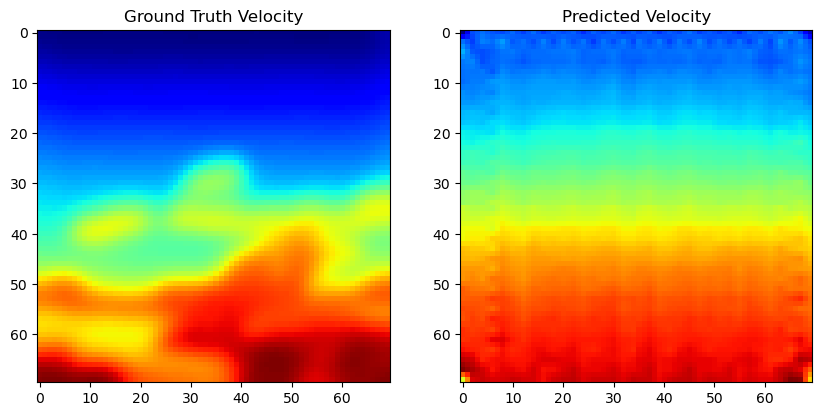

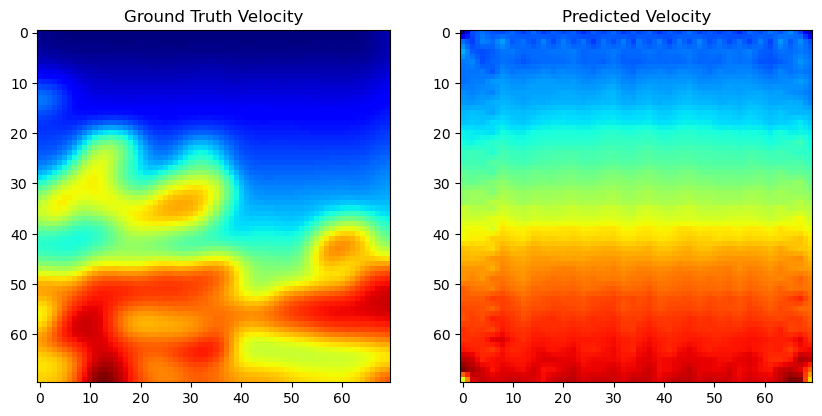

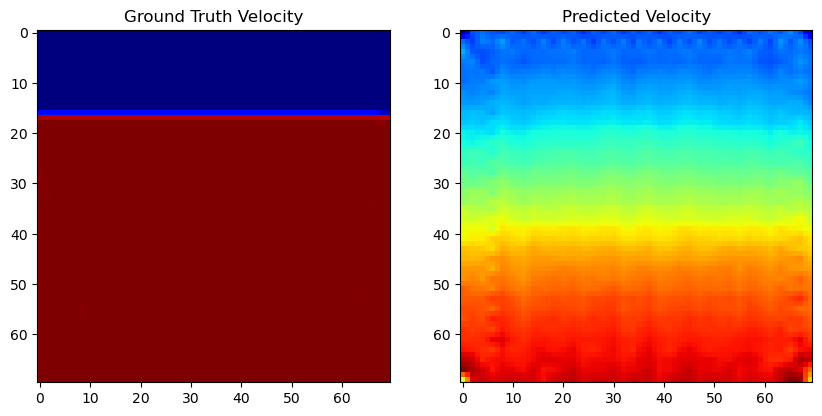

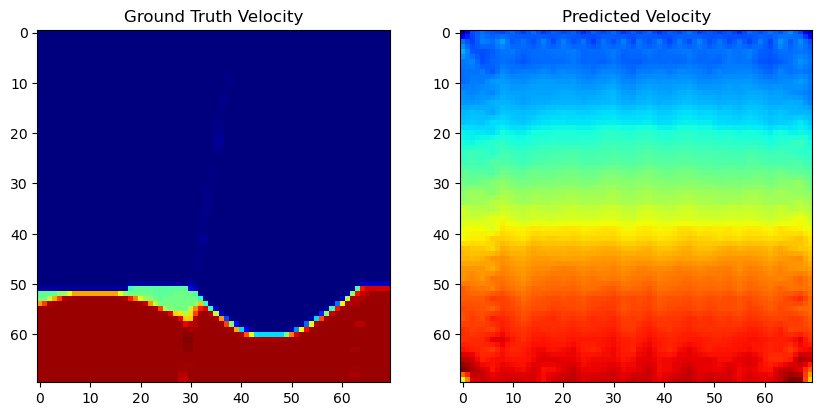

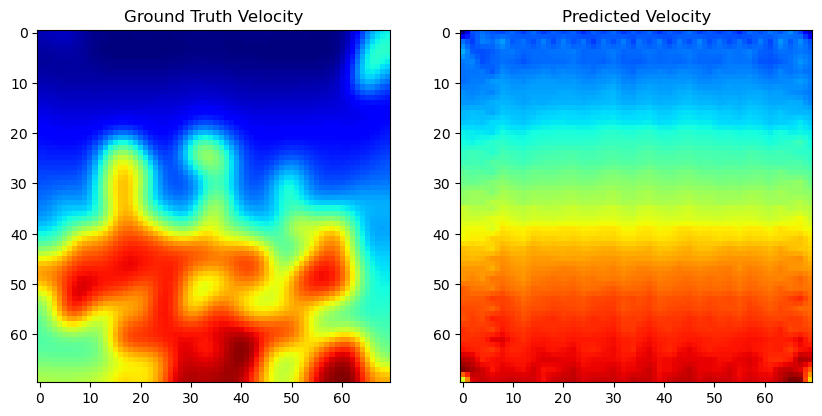

In [21]:
model = model.to(device)
model.eval()
inputs, targets = next(iter(val_loader))
# inputs, targets = inputs.to(device), targets.to(device)
def vel_denorm(t):
    return (t + 1) / 2 * (4500.0 - 1500.0) + 1500.0


with torch.no_grad():
    times = torch.Tensor([1.0]).to(device)
    predictions = model(times=times, x=inputs)
    predictions = predictions.squeeze(0)
    predictions = predictions[-1, :]

vel_denorm_pred = vel_denorm(predictions).cpu().numpy()
vel_denorm_true = vel_denorm(targets).cpu().numpy()
for i in range(min(5, inputs.size(0))):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(targets[i][0].cpu(), cmap='jet')
    axs[0].set_title('Ground Truth Velocity')
    axs[1].imshow(predictions[i][0].cpu(), cmap='jet')
    axs[1].set_title('Predicted Velocity')
    plt.show()

### Full Augmented Neural ODE

In [13]:
class AugmentedNeuralODE(nn.Module):
    def __init__(self, latent_state, tolerance, max_steps):
        super().__init__()
        self.encoder = SeismicEncoder(latent_state)
        self.decoder = VelocityDecoder(latent_state+1) 
        self.neural_ode_model = ODEFunc(latent_state+1)
        self.tolerance = tolerance
        self.max_steps = max_steps
    
    def forward(self, x, times=None):
        x = x.to(device)
        x = self.encoder(x)
        if times is None:
            times = torch.tensor([1.0]).float().type_as(x)
            times = times.to(device)
        x = torch.cat([x, torch.zeros(x.shape[0], x.shape[1], 1, device=x.device)], dim=-1).to(device)
        # print(x.shape)
        y = odeint(func=self.neural_ode_model, 
                   y0=x, 
                   t=times, 
                   atol=self.tolerance, 
                   rtol=self.tolerance, 
                   method='dopri5', 
                   options={'max_num_steps':self.max_steps})
        # print(y.shape)
        _, batch_size, timestep, latent = y.shape
        pred = self.decoder(y)
        pred = pred.to(device)
        pred = pred.view(timestep, batch_size, 1, 70, 70)
        return pred

### Training of Augmented Neural ODE

In [25]:
model = AugmentedNeuralODE(64, 1e-3, 100)
step_size = 10
# model = model.to(device)
# Define loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

# Training loop
num_epochs = 50
model = model.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        B, __, T, C = inputs.shape
        # times = torch.linspace(0, 1, steps=T, device=device)
        times = torch.Tensor([1.0]).to(device)
        outputs = model(times=times, x=inputs)
        outputs = outputs.squeeze(0)
        outputs = outputs[-1,:]
        # aug = torch.zeros(targets.shape[0], targets.shape[1], targets.shape[2], 1)
        # aug = aug.to(device)
        # targets = torch.cat([targets, aug], -1)
        # print(targets.shape)
        # print(outputs.shape)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    scheduler.step()
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            t = torch.tensor([1.0]).to(device)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(times=times, x=inputs)
            outputs = outputs.squeeze(0)
            outputs = outputs[-1,:]
            # aug = torch.zeros(targets.shape[0], targets.shape[1], targets.shape[2], 1)
            # targets = torch.cat([targets, aug], -1)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train MAE: {train_loss:.4f} Val MAE: {val_loss:.4f}")

Epoch 1/50: 100%|██████████| 175/175 [00:19<00:00,  8.83it/s]


Epoch [1/50] Train MAE: 1562.7723 Val MAE: 610.7497


Epoch 2/50: 100%|██████████| 175/175 [00:19<00:00,  8.87it/s]


Epoch [2/50] Train MAE: 584.9748 Val MAE: 567.1219


Epoch 3/50: 100%|██████████| 175/175 [00:19<00:00,  8.93it/s]


Epoch [3/50] Train MAE: 548.0592 Val MAE: 534.7712


Epoch 4/50: 100%|██████████| 175/175 [00:19<00:00,  8.83it/s]


Epoch [4/50] Train MAE: 518.7684 Val MAE: 508.5414


Epoch 5/50: 100%|██████████| 175/175 [00:19<00:00,  8.82it/s]


Epoch [5/50] Train MAE: 504.1563 Val MAE: 495.3272


Epoch 6/50: 100%|██████████| 175/175 [00:19<00:00,  8.76it/s]


Epoch [6/50] Train MAE: 487.5120 Val MAE: 484.2802


Epoch 7/50: 100%|██████████| 175/175 [00:19<00:00,  8.85it/s]


Epoch [7/50] Train MAE: 485.4520 Val MAE: 481.0114


Epoch 8/50: 100%|██████████| 175/175 [00:20<00:00,  8.74it/s]


Epoch [8/50] Train MAE: 485.5393 Val MAE: 490.8661


Epoch 9/50: 100%|██████████| 175/175 [00:19<00:00,  8.93it/s]


Epoch [9/50] Train MAE: 475.0990 Val MAE: 479.5758


Epoch 10/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [10/50] Train MAE: 475.3752 Val MAE: 473.1002


Epoch 11/50: 100%|██████████| 175/175 [00:19<00:00,  8.80it/s]


Epoch [11/50] Train MAE: 473.0871 Val MAE: 482.3212


Epoch 12/50: 100%|██████████| 175/175 [00:19<00:00,  8.91it/s]


Epoch [12/50] Train MAE: 472.2717 Val MAE: 475.1733


Epoch 13/50: 100%|██████████| 175/175 [00:19<00:00,  8.88it/s]


Epoch [13/50] Train MAE: 470.8101 Val MAE: 471.2392


Epoch 14/50: 100%|██████████| 175/175 [00:20<00:00,  8.73it/s]


Epoch [14/50] Train MAE: 470.8882 Val MAE: 471.2495


Epoch 15/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [15/50] Train MAE: 470.2618 Val MAE: 470.8874


Epoch 16/50: 100%|██████████| 175/175 [00:19<00:00,  8.77it/s]


Epoch [16/50] Train MAE: 470.9808 Val MAE: 470.0088


Epoch 17/50: 100%|██████████| 175/175 [00:20<00:00,  8.73it/s]


Epoch [17/50] Train MAE: 470.0296 Val MAE: 483.5796


Epoch 18/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [18/50] Train MAE: 470.5977 Val MAE: 470.3750


Epoch 19/50: 100%|██████████| 175/175 [00:19<00:00,  8.81it/s]


Epoch [19/50] Train MAE: 471.3409 Val MAE: 490.7664


Epoch 20/50: 100%|██████████| 175/175 [00:19<00:00,  8.85it/s]


Epoch [20/50] Train MAE: 469.5513 Val MAE: 470.5834


Epoch 21/50: 100%|██████████| 175/175 [00:20<00:00,  8.74it/s]


Epoch [21/50] Train MAE: 467.3727 Val MAE: 468.8109


Epoch 22/50: 100%|██████████| 175/175 [00:19<00:00,  8.79it/s]


Epoch [22/50] Train MAE: 467.6591 Val MAE: 469.4890


Epoch 23/50: 100%|██████████| 175/175 [00:19<00:00,  8.79it/s]


Epoch [23/50] Train MAE: 468.5969 Val MAE: 469.5639


Epoch 24/50: 100%|██████████| 175/175 [00:19<00:00,  8.83it/s]


Epoch [24/50] Train MAE: 468.0660 Val MAE: 469.3418


Epoch 25/50: 100%|██████████| 175/175 [00:19<00:00,  8.89it/s]


Epoch [25/50] Train MAE: 467.2126 Val MAE: 469.9064


Epoch 26/50: 100%|██████████| 175/175 [00:19<00:00,  8.83it/s]


Epoch [26/50] Train MAE: 468.7871 Val MAE: 468.3238


Epoch 27/50: 100%|██████████| 175/175 [00:19<00:00,  8.84it/s]


Epoch [27/50] Train MAE: 467.1421 Val MAE: 469.2518


Epoch 28/50: 100%|██████████| 175/175 [00:19<00:00,  8.78it/s]


Epoch [28/50] Train MAE: 467.7498 Val MAE: 474.1148


Epoch 29/50: 100%|██████████| 175/175 [00:19<00:00,  8.82it/s]


Epoch [29/50] Train MAE: 468.6795 Val MAE: 468.3742


Epoch 30/50: 100%|██████████| 175/175 [00:19<00:00,  8.88it/s]


Epoch [30/50] Train MAE: 467.6693 Val MAE: 470.1156


Epoch 31/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [31/50] Train MAE: 465.8789 Val MAE: 469.9999


Epoch 32/50: 100%|██████████| 175/175 [00:19<00:00,  8.86it/s]


Epoch [32/50] Train MAE: 465.7590 Val MAE: 468.2754


Epoch 33/50: 100%|██████████| 175/175 [00:19<00:00,  8.91it/s]


Epoch [33/50] Train MAE: 466.0598 Val MAE: 467.9746


Epoch 34/50: 100%|██████████| 175/175 [00:19<00:00,  8.94it/s]


Epoch [34/50] Train MAE: 466.3243 Val MAE: 467.9480


Epoch 35/50: 100%|██████████| 175/175 [00:19<00:00,  8.86it/s]


Epoch [35/50] Train MAE: 465.5270 Val MAE: 468.8310


Epoch 36/50: 100%|██████████| 175/175 [00:19<00:00,  8.90it/s]


Epoch [36/50] Train MAE: 466.2530 Val MAE: 468.2469


Epoch 37/50: 100%|██████████| 175/175 [00:19<00:00,  8.95it/s]


Epoch [37/50] Train MAE: 466.9831 Val MAE: 468.9265


Epoch 38/50: 100%|██████████| 175/175 [00:19<00:00,  8.77it/s]


Epoch [38/50] Train MAE: 466.1848 Val MAE: 469.2357


Epoch 39/50: 100%|██████████| 175/175 [00:19<00:00,  8.97it/s]


Epoch [39/50] Train MAE: 466.1153 Val MAE: 468.2660


Epoch 40/50: 100%|██████████| 175/175 [00:19<00:00,  8.83it/s]


Epoch [40/50] Train MAE: 466.2944 Val MAE: 468.3339


Epoch 41/50: 100%|██████████| 175/175 [00:19<00:00,  8.82it/s]


Epoch [41/50] Train MAE: 465.2908 Val MAE: 468.6030


Epoch 42/50: 100%|██████████| 175/175 [00:19<00:00,  8.96it/s]


Epoch [42/50] Train MAE: 465.4356 Val MAE: 468.3184


Epoch 43/50: 100%|██████████| 175/175 [00:19<00:00,  8.93it/s]


Epoch [43/50] Train MAE: 465.9005 Val MAE: 468.0333


Epoch 44/50: 100%|██████████| 175/175 [00:19<00:00,  8.93it/s]


Epoch [44/50] Train MAE: 465.7415 Val MAE: 468.1362


Epoch 45/50: 100%|██████████| 175/175 [00:19<00:00,  8.95it/s]


Epoch [45/50] Train MAE: 465.3611 Val MAE: 468.1105


Epoch 46/50: 100%|██████████| 175/175 [00:19<00:00,  8.93it/s]


Epoch [46/50] Train MAE: 465.0078 Val MAE: 468.0273


Epoch 47/50: 100%|██████████| 175/175 [00:19<00:00,  8.95it/s]


Epoch [47/50] Train MAE: 466.6268 Val MAE: 468.4934


Epoch 48/50: 100%|██████████| 175/175 [00:19<00:00,  8.97it/s]


Epoch [48/50] Train MAE: 465.2742 Val MAE: 468.3168


Epoch 49/50: 100%|██████████| 175/175 [00:19<00:00,  8.96it/s]


Epoch [49/50] Train MAE: 465.3451 Val MAE: 468.2991


Epoch 50/50: 100%|██████████| 175/175 [00:19<00:00,  8.92it/s]


Epoch [50/50] Train MAE: 465.6957 Val MAE: 468.0219


In [14]:
model = AugmentedNeuralODE(64, 1e-3, 100)
model.load_state_dict(torch.load('AugmentedNeuralODE', map_location=torch.device('cpu')))
test_model(test_loader, model)

{'Test MAE': 471.3714628092448,
 'Test RMSE': 595.1661547851562,
 'Test SSIM': tensor(0.8759),
 'Relative L2 Error': 0.19861093839009603}

In [28]:
torch.save(model.state_dict(), "AugmentedNeuralODE")

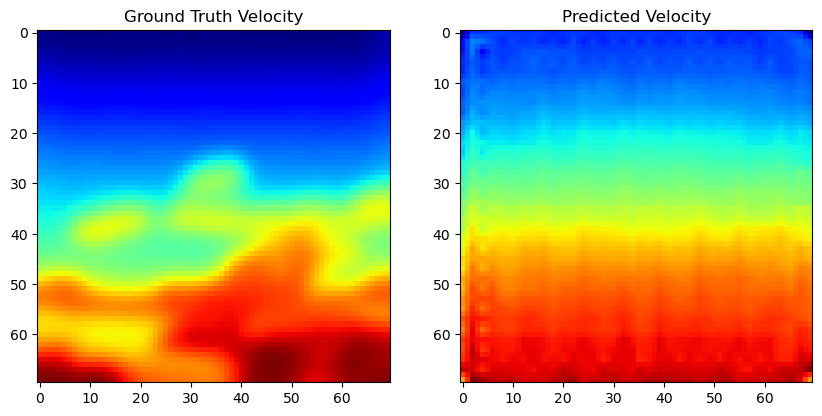

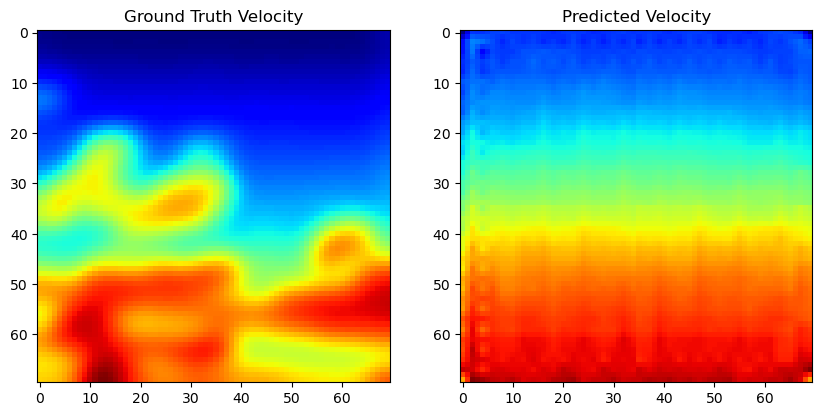

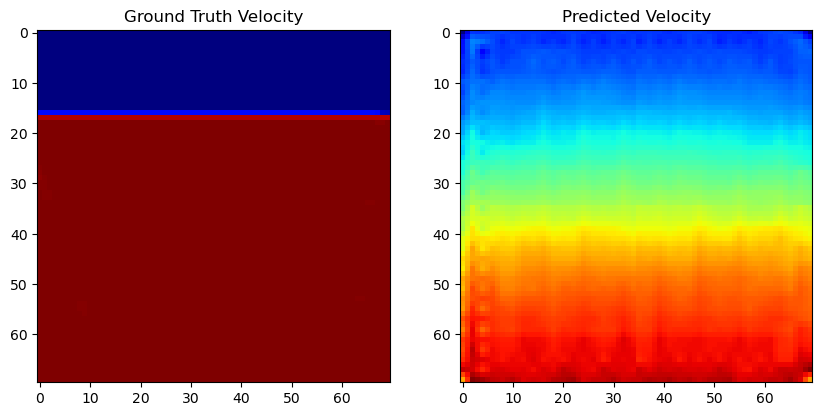

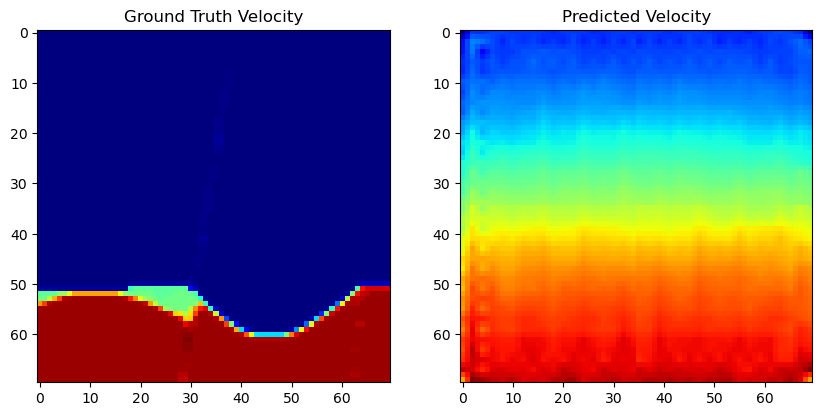

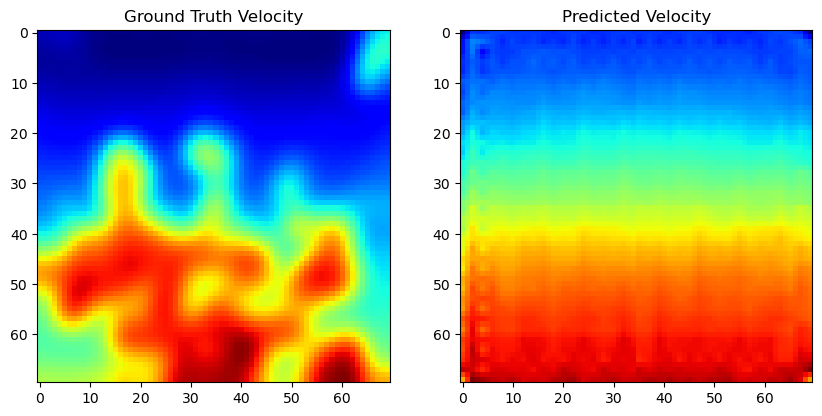

In [31]:
model = model.to(device)
model.eval()
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)
with torch.no_grad():
    times = torch.Tensor([1.0]).to(device)
    predictions = model(times=times, x=inputs)
    predictions = predictions.squeeze(0)
    predictions = predictions[-1, :]

for i in range(min(5, inputs.size(0))):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(targets[i][0].cpu(), cmap='jet')
    axs[0].set_title('Ground Truth Velocity')
    axs[1].imshow(predictions[i][0].cpu(), cmap='jet')
    axs[1].set_title('Predicted Velocity')
    plt.show()

### Further Visualizations